# SMI Post Analysis
--> Version 1, Dev March 2, 2018
    Load Qmap and do circular average

In [1]:
%matplotlib notebook
from pySMI.smi_libs import *
from pySMI.smi_package import *
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })

from databroker import Broker
db = Broker.named('smi')

/opt/conda_envs/analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from skimage.draw import line_aa, line, polygon, ellipse, circle

In [3]:
%run ~/pySMI/pySMI/smi_circular_average.py

## Define input/output data path

In [53]:
proposal_id = '302738_1'
inDir = '/GPFS/xf12id1/data/1M/images/users/%s/'%(proposal_id)
ResDir0 = '/GPFS/xf12id1/analysis/2018_1/%s/Results/'%('Gang')
ResDir = os.path.join( ResDir0, 'Brian/'  )
os.makedirs(ResDir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % ResDir)

Results from this analysis will be stashed in the directory /GPFS/xf12id1/analysis/2018_1/Gang/Results/Brian/


## Beamline parameter

In [50]:
beam_x = 513
beam_y = 565
energy = 16.1 #keV
wavelength_A =12.39842/energy
sam_det = 8.3 #in meters

In [51]:

dq = 4*np.pi/wavelength_A  * (172/1e6/sam_det)

calibration = CalibrationGonio(wavelength_A= wavelength_A) # 20.0 keV
calibration.set_image_size(195, height=1475) # Pilatus300kW vertical
#calibration.set_image_size(1475, height=195) # Pilatus300kW horizontal
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(beam_x,  beam_y )
calibration.set_distance( sam_det )
calibration.set_angles(det_phi_g=0., det_theta_g=0., )
print('ratio Dw = {:.3f}'.format(calibration.get_ratioDw()))
mask_dir = '/GPFS/xf12id1/analysis/commissioning/masks/'
##for 300KW
mask = Mask(mask_dir+'Pilatus300kWh_main_gaps-mask.png')
mask.load(mask_dir+'Pilatus300kWh_current-mask.png')
#mask.load('./Pilatus300kWh_current-mask.png')
## for 1M
mask = Mask(mask_dir+'Pilatus1M_main_gaps-mask.png')
mask.load(mask_dir+'Pilatus1M_main_gaps-mask.png')
ma = (mask.data).T

ratio Dw = 247.466


<IPython.core.display.Javascript object>


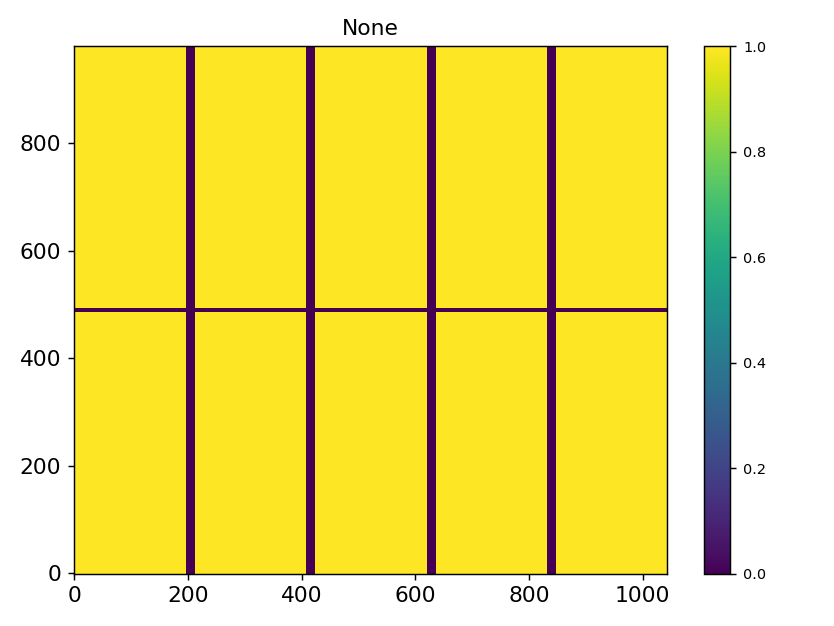

In [33]:
show_img(ma.T)

In [34]:
img.shape, ma.T.shape

((981, 1043), (981, 1043))

## Beam Stop Mask

In [44]:
ms = np.ones_like( ma )
ms[500:525,:] = 0
msk = ma* ms

## Check one sample

In [95]:
#fn = 'P63_largebeam_time_series_30s_redo_000005_SAXS.tif'
fn =  'F5_largebeam_time_series_30s_redo_000001_SAXS.tif'
fn = 'F5_largebeam_time_series_30s_again_000002_SAXS.tif'
#fn = 'F5_largebeam_time_series_30s_redo_000003_SAXS.tif'
fn = 'F5_largebeam_time_series_000001_SAXS.tif'



In [96]:
img = np.array(  PIL.Image.open(inDir + fn ).convert('I') ).T/1.0  *msk

<IPython.core.display.Javascript object>


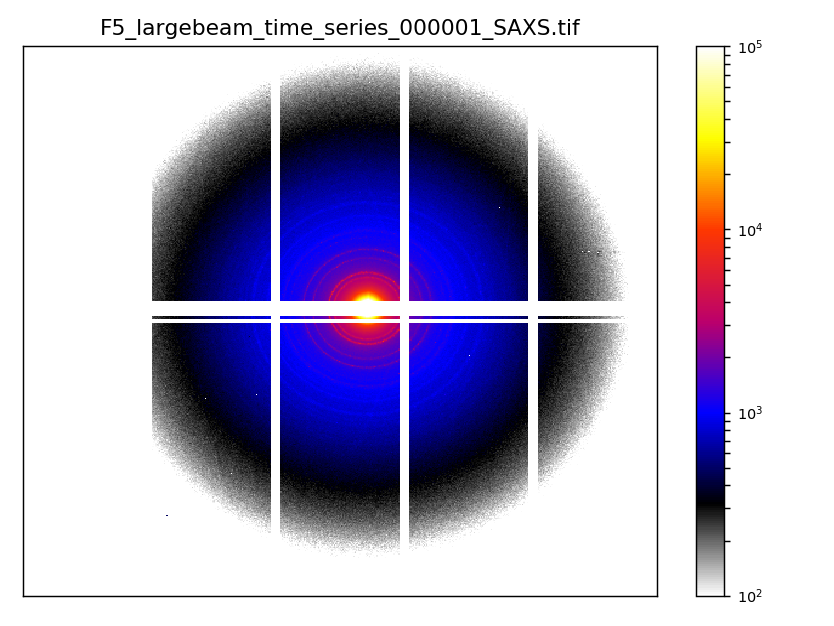

/opt/conda_envs/analysis/lib/python3.6/site-packages/matplotlib/colorbar.py:821: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  y[self._inside] = norm(yi)


In [116]:
show_img( img, logs = True, show_colorbar= True,show_ticks =False,
             image_name= '%s'%fn, cmap = cmap_vge_hdr,  vmin= 100, vmax= 1e5  )





# Do Circular Average here

In [158]:
ResDir

'/GPFS/xf12id1/analysis/2018_1/Gang/Results/Brian/'

In [159]:
energy = 16.1  

setup_pargs =  {'Ldet': 8.3 *1000 ,  
 'center': [513,565],
 'dpix': 0.172,  
 'lambda_': 12.39842/energy,
 'path': ResDir,
 'uid': fn[:-4],
}


In [160]:
%run ~/pySMI/pySMI/smi_circular_average.py

In [161]:
#hmask = create_hot_pixel_mask( qmap, threshold = 1e-1, center=center, center_radius= 800) #*Chip_Mask
qp_saxs, iq_saxs, q_saxs = get_circular_average( img *msk , msk, pargs=setup_pargs  )


In [162]:
#514 - 456, 514-449, 514 - 423, 514 - 406

<IPython.core.display.Javascript object>


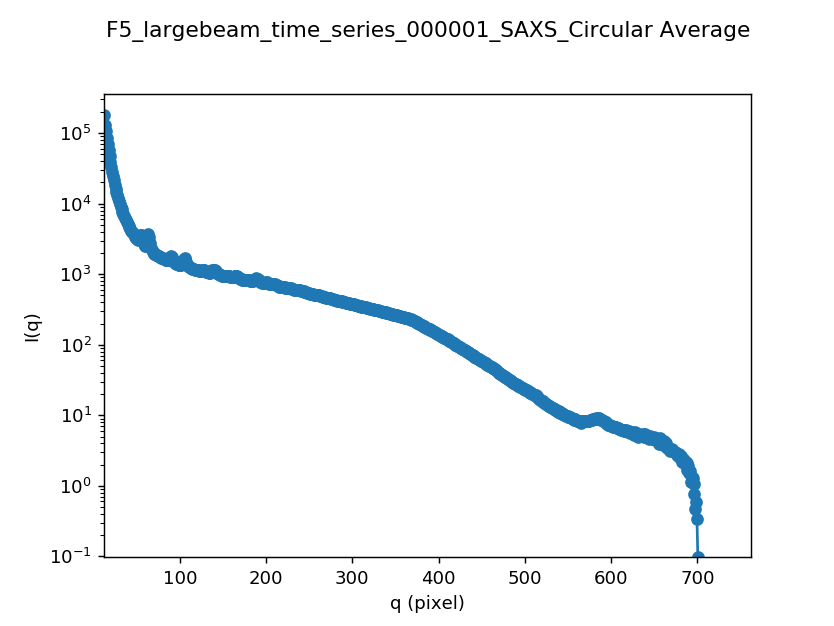

In [163]:
plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )

In [164]:
d = np.hstack( [  q_saxs.reshape([len(q_saxs),1]), iq_saxs.reshape( [len(iq_saxs),1] ) ] )
np.savetxt(    ResDir + fn[:-4]+ '.txt', d )

<IPython.core.display.Javascript object>


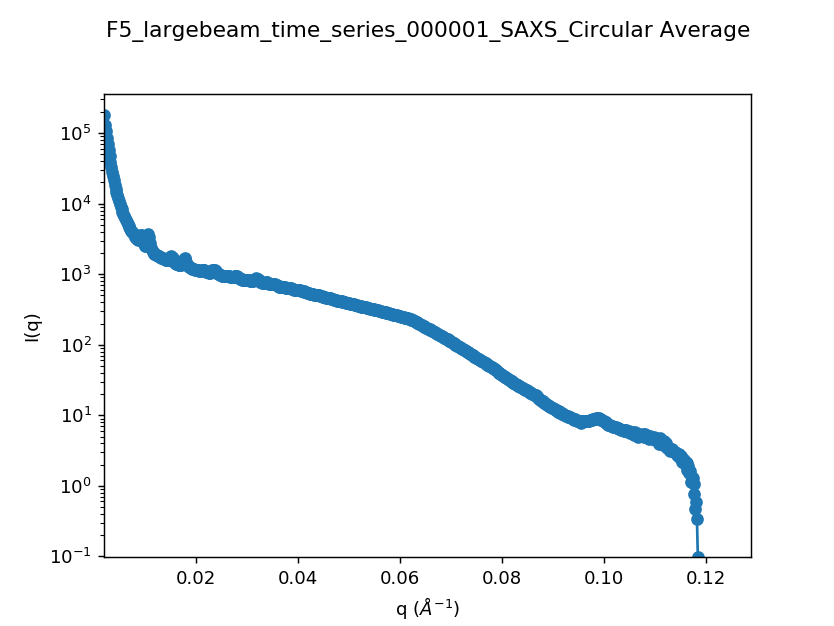

In [165]:
plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=False,
                      xlim=[q_saxs.min(), q_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )

In [166]:
#plot1D( x =  q_saxs/0.00928, y = iq_saxs, logy=True)